In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
from typing import List
from urllib.parse import urlparse
import random

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine

In [4]:
import matplotlib.pyplot as plt

## Connect to database and query data

In [5]:
PROJECT_SRC = '/workspace/src'
os.chdir(PROJECT_SRC)
    
SQLALCHEMY_DATABASE_URI='sqlite:///../data/database.db'
engine = create_engine(SQLALCHEMY_DATABASE_URI, echo=False)

In [6]:
with engine.connect() as conn:
    
    join_txt='''
    SELECT 
        g.dttm, 
        wind, 
        solar, 
        load_mwh,
        price
    FROM GENERATION as g
    INNER JOIN
    LOAD as l
    ON g.dttm = l.dttm
    INNER JOIN
    PRICE as p
    ON g.dttm = p.dttm
    
    '''
    
    data = pd.read_sql(join_txt, engine)
    
data


,dttm,wind,solar,load_mwh,price
0,2020-01-01 01:00:00.000000,12443.0,0.0,16368.09,12.52
1,2020-01-01 02:00:00.000000,12338.8,0.0,15948.21,12.35
2,2020-01-01 03:00:00.000000,12075.4,0.0,15586.64,12.06
3,2020-01-01 04:00:00.000000,11957.9,0.0,15336.74,11.97
4,2020-01-01 05:00:00.000000,12012.6,0.0,15288.27,12.37
...,...,...,...,...,...
21331,2022-06-07 20:00:00.000000,2421.1,76.9,17522.10,89.35
21332,2022-06-07 21:00:00.000000,2375.1,5.3,17342.36,77.73
21333,2022-06-07 22:00:00.000000,2391.7,0.0,17100.03,70.13
21334,2022-06-07 23:00:00.000000,2348.4,0.0,16229.20,63.36


In [7]:
data.dttm = pd.to_datetime(data.dttm)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21336 entries, 0 to 21335
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dttm      21336 non-null  datetime64[ns]
 1   wind      21335 non-null  float64       
 2   solar     21334 non-null  float64       
 3   load_mwh  21336 non-null  float64       
 4   price     21336 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 833.6 KB


In [9]:
# find any gaps in timeseries
all_hours = pd.DataFrame({'dttm':pd.date_range(data.dttm.min(), data.dttm.max(), freq='H')})
data = all_hours.merge(data, on='dttm', how='left')

In [10]:
data.describe()

,wind,solar,load_mwh,price
count,21335.000000,21334.000000,21336.000000,21336.000000
mean,7461.402747,43.089552,16689.353952,29.165156
std,4110.877294,67.299780,2425.926154,28.765352
min,11.500000,0.000000,10772.120000,-57.560000
25%,3892.700000,0.000000,14931.120000,16.067500
50%,7300.400000,0.500000,16506.295000,21.950000
75%,10985.250000,73.775000,18193.005000,34.900000
max,17027.700000,405.500000,25715.570000,888.140000


In [11]:
data.isna().sum()

dttm        0
wind        1
solar       2
load_mwh    0
price       0
dtype: int64

In [12]:
data.fillna(method='ffill', inplace=True)

In [13]:
data.isna().sum()

dttm        0
wind        0
solar       0
load_mwh    0
price       0
dtype: int64

In [14]:
data.set_index('dttm', inplace=True)

In [15]:
data

,wind,solar,load_mwh,price
dttm,,,,
2020-01-01 01:00:00,12443.0,0.0,16368.09,12.52
2020-01-01 02:00:00,12338.8,0.0,15948.21,12.35
2020-01-01 03:00:00,12075.4,0.0,15586.64,12.06
2020-01-01 04:00:00,11957.9,0.0,15336.74,11.97
2020-01-01 05:00:00,12012.6,0.0,15288.27,12.37
...,...,...,...,...
2022-06-07 20:00:00,2421.1,76.9,17522.10,89.35
2022-06-07 21:00:00,2375.1,5.3,17342.36,77.73
2022-06-07 22:00:00,2391.7,0.0,17100.03,70.13


<AxesSubplot:>

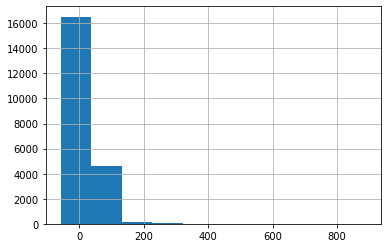

In [16]:
data.price.hist()

In [17]:
np.percentile(data.price, (0.5, 99.25))

array([ -6.056   , 140.319625])

In [18]:
MAX_PRICE = 175
data.loc[data.price > MAX_PRICE, 'price'] = MAX_PRICE

In [19]:
data.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,7461.330062,43.085527,16689.353952,28.596543
std,4110.794662,67.297909,2425.926154,22.838198
min,11.500000,0.000000,10772.120000,-57.560000
25%,3892.700000,0.000000,14931.120000,16.067500
50%,7299.000000,0.500000,16506.295000,21.950000
75%,10985.025000,73.725000,18193.005000,34.900000
max,17027.700000,405.500000,25715.570000,175.000000


## Data scaling

In [20]:
# define lookback and lookforward periods for 
# gathering training/test sets and creating
# t_idx: a data frame time indexes for the 
# lookback and lookforward periods
LOOKBACK = 23 
LOOKFORWARD = 24

In [21]:
# get training and test indexes
np.random.seed(42)
TRAIN_IDX = np.random.choice(range(data.shape[0]-LOOKBACK-LOOKFORWARD), size=int(0.8*len(data)), replace=False)
TRAIN_IDX

array([20662,  5921, 14187, ...,  1717,  2696,  1848])

In [22]:
TEST_IDX = np.setdiff1d(range(data.shape[0]-LOOKBACK-LOOKFORWARD),TRAIN_IDX)
TEST_IDX

array([    9,    11,    13, ..., 21281, 21286, 21288])

### Gather scaler metrics

In [23]:
scaler = {}
scaler['means'] = data.iloc[TRAIN_IDX,:].mean()
scaler['means']

wind         7459.590831
solar          42.801558
load_mwh    16695.477854
price          28.517849
dtype: float64

In [24]:
scaler['sd'] = data.iloc[TRAIN_IDX,:].std()
scaler['sd']

wind        4109.340388
solar         67.098413
load_mwh    2425.745195
price         22.721287
dtype: float64

### define scaling functions

In [25]:
def scale_data(data, scaler):
    return ((data - scaler['means'])/scaler['sd'])

data_scaled = scale_data(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,0.000423,0.004232,-0.002525,0.003463
std,1.000354,1.002973,1.000075,1.005145
min,-1.812478,-0.637892,-2.441871,-3.788423
25%,-0.867996,-0.637892,-0.727347,-0.547960
50%,-0.039079,-0.630441,-0.077990,-0.289061
75%,0.857908,0.460867,0.617347,0.280889
max,2.328381,5.405470,3.718483,6.446913


In [26]:
def unscale_data(data_scaled, scaler):
    return data_scaled*scaler['sd'] + scaler['means']

In [27]:
data = unscale_data(data_scaled, scaler)
data.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,7461.330062,43.085527,16689.353952,28.596543
std,4110.794662,67.297909,2425.926154,22.838198
min,11.500000,0.000000,10772.120000,-57.560000
25%,3892.700000,0.000000,14931.120000,16.067500
50%,7299.000000,0.500000,16506.295000,21.950000
75%,10985.025000,73.725000,18193.005000,34.900000
max,17027.700000,405.500000,25715.570000,175.000000


### Create scaling data set for use in modeling

In [28]:
data_scaled = scale_data(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,0.000423,0.004232,-0.002525,0.003463
std,1.000354,1.002973,1.000075,1.005145
min,-1.812478,-0.637892,-2.441871,-3.788423
25%,-0.867996,-0.637892,-0.727347,-0.547960
50%,-0.039079,-0.630441,-0.077990,-0.289061
75%,0.857908,0.460867,0.617347,0.280889
max,2.328381,5.405470,3.718483,6.446913


## Create `t_idx` dataframe
`t_idx` has `t_start`, `t_now`, and `t_end` columns which define the start and end points of a sample based on the `LOOKBACK` and `LOOKFORWARD` windows.  This data frame is used in the data loader to produce samples.

In [29]:
def create_t_idx(
    data: pd.core.frame.DataFrame, 
    LOOKBACK: int, 
    LOOKFORWARD: int
) -> pd.core.frame.DataFrame:
    
    t_idx = pd.DataFrame()
    t_idx['t_start'] = data.index
    t_idx['t_now'] = data.index.shift(LOOKBACK, freq='H')
    t_idx['t_end'] = data.index.shift(LOOKBACK+LOOKFORWARD, freq='H')
    t_idx = t_idx[t_idx.t_end <= t_idx.t_start.max()]
    return t_idx

In [30]:
t_idx = create_t_idx(data, LOOKBACK, LOOKFORWARD)
t_idx

,t_start,t_now,t_end
0,2020-01-01 01:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00
1,2020-01-01 02:00:00,2020-01-02 01:00:00,2020-01-03 01:00:00
2,2020-01-01 03:00:00,2020-01-02 02:00:00,2020-01-03 02:00:00
3,2020-01-01 04:00:00,2020-01-02 03:00:00,2020-01-03 03:00:00
4,2020-01-01 05:00:00,2020-01-02 04:00:00,2020-01-03 04:00:00
...,...,...,...
21284,2022-06-05 21:00:00,2022-06-06 20:00:00,2022-06-07 20:00:00
21285,2022-06-05 22:00:00,2022-06-06 21:00:00,2022-06-07 21:00:00
21286,2022-06-05 23:00:00,2022-06-06 22:00:00,2022-06-07 22:00:00
21287,2022-06-06 00:00:00,2022-06-06 23:00:00,2022-06-07 23:00:00


## Test getting data from time indexes

In [31]:
# test_idx = 21118
test_idx = 0
t_idx.iloc[test_idx,:]

t_start   2020-01-01 01:00:00
t_now     2020-01-02 00:00:00
t_end     2020-01-03 00:00:00
Name: 0, dtype: datetime64[ns]

In [32]:
# get dataframe with historical and future timeseries values
# i.e. historical values from t_start:t_now and 
# future values from t_now:t_end
# in production future values would come from forecasts 
# but actuals will be used for training
hist_future_cols = ['wind', 'solar', 'load_mwh']
hist_future = data_scaled.loc[t_idx.t_start[test_idx]:t_idx.t_end[test_idx], hist_future_cols]
hist_future

,wind,solar,load_mwh
dttm,,,
2020-01-01 01:00:00,1.212703,-0.637892,-0.134964
2020-01-01 02:00:00,1.187346,-0.637892,-0.308057
2020-01-01 03:00:00,1.123248,-0.637892,-0.457112
2020-01-01 04:00:00,1.094655,-0.637892,-0.560132
2020-01-01 05:00:00,1.107966,-0.637892,-0.580114
2020-01-01 06:00:00,1.102977,-0.637892,-0.552324
2020-01-01 07:00:00,1.034280,-0.637892,-0.458147
2020-01-01 08:00:00,0.906912,-0.637892,-0.384689
2020-01-01 09:00:00,0.770418,-0.637892,-0.275502


In [33]:
# get dataframe with historical timeseries values
label_cols = ['price']
hist = data_scaled.loc[t_idx.t_start[test_idx]:t_idx.t_now[test_idx], label_cols]
hist

,price
dttm,
2020-01-01 01:00:00,-0.704091
2020-01-01 02:00:00,-0.711573
2020-01-01 03:00:00,-0.724336
2020-01-01 04:00:00,-0.728297
2020-01-01 05:00:00,-0.710693
2020-01-01 06:00:00,-0.609906
2020-01-01 07:00:00,-0.565454
2020-01-01 08:00:00,-0.618708
2020-01-01 09:00:00,-0.570736


In [34]:
# get dataframe with future timeseries label values
# this is what we're trying to predict
label_cols = ['price']
label = data_scaled.loc[(t_idx.t_now[test_idx]+pd.DateOffset(hours=1)):t_idx.t_end[test_idx], label_cols]
label

,price
dttm,
2020-01-02 01:00:00,-0.591421
2020-01-02 02:00:00,-0.656558
2020-01-02 03:00:00,-0.687366
2020-01-02 04:00:00,-0.722136
2020-01-02 05:00:00,-0.758225
2020-01-02 06:00:00,-0.725216
2020-01-02 07:00:00,-0.664920
2020-01-02 08:00:00,-0.712453
2020-01-02 09:00:00,-0.713773


In [35]:
# function to create tabular data from t_now index
# this will consist of one hot encoding for timestamp variables
def create_tabular_data(
    t_now: pd._libs.tslibs.timestamps.Timestamp
) -> pd.core.frame.DataFrame:
    
    hours = pd.DataFrame({f'hour_{i}':1*(t_now.hour == i) for i in range(24)}, index=[0])
    dayofweek = pd.DataFrame({f'dayofweek_{i}':1*(t_now.dayofweek == i) for i in range(7)}, index=[0])
    month = pd.DataFrame({f'month_{i}':1*(t_now.month == i) for i in range(1, 13)}, index=[0])
    # week = pd.DataFrame({f'week_{i}':1*(t_now.isocalendar()[1] == i) for i in range(1, 54)}, index=[0])
    day = pd.DataFrame({f'day_{i}':1*(t_now.day == i) for i in range(1,32)}, index=[0])
        
        
    return pd.concat([day, month, dayofweek, hours], axis=1)

In [36]:
tabular_data = create_tabular_data(t_idx.t_now[test_idx])
tabular_data.transpose()

,0
day_1,0
day_2,1
day_3,0
day_4,0
day_5,0
...,...
hour_19,0
hour_20,0
hour_21,0
hour_22,0


## Custom dataloader

In [37]:
# this the class for our custom data loader
# it will return our timeseries dataframes, tabular data, and target values
class CombineDataset(Dataset):

    def __init__(self, t_idx, data_scaled, hist_future_cols, label_cols):
        """
        Args:
            t_idx (pd.DataFrame): DataFrame with t_start, t_now, t_end columns
            t_idx (pd.DataFrame): DataFrame with wind, solar, load_mwh, price columns
            hist_future_cols (List[str]): List of column names with historical and future values
            label_cols (List[str]): List of label column names, used to create hist and label data
        Returns:
            hist_future (numpy.ndarray): sample with historical and future 
                wind, solar, load_mwh timeseries values
            hist (numpy.ndarray): sample with historical price time series values
            tabular (numpy.ndarray): sample with tabular data
            label (numpy.ndarray): sample with future prices that is used for the target variable
        """
        self.t_idx = t_idx
        self.data_scaled = data_scaled
        self.hist_future_cols = hist_future_cols
        self.label_cols = label_cols

    def __len__(self):
        return (self.t_idx.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # print(f'idx: {idx}')
        
        # get historical and future timeseries
        hist_future = self.data_scaled.loc[
            self.t_idx.t_start[idx]:self.t_idx.t_end[idx], self.hist_future_cols
        ].transpose()

        # get historical label timeseries
        hist = self.data_scaled.loc[
            self.t_idx.t_start[idx]:self.t_idx.t_now[idx], self.label_cols
        ].transpose()
       
        # get tabular data
        tabular = create_tabular_data(self.t_idx.t_now[idx])
        
        # get label timeseries
        label = self.data_scaled.loc[
            (self.t_idx.t_now[idx]+pd.DateOffset(hours=1)):self.t_idx.t_end[idx], self.label_cols
        ].transpose()

        return hist_future.values, hist.values, tabular.values, label.values

In [38]:
# create t_idx_train and t_idx_test for train and test dataloaders
t_idx_train = t_idx.iloc[TRAIN_IDX,:].reset_index(drop=True)
t_idx_train

,t_start,t_now,t_end
0,2022-05-10 23:00:00,2022-05-11 22:00:00,2022-05-12 22:00:00
1,2020-09-03 18:00:00,2020-09-04 17:00:00,2020-09-05 17:00:00
2,2021-08-14 04:00:00,2021-08-15 03:00:00,2021-08-16 03:00:00
3,2021-12-04 17:00:00,2021-12-05 16:00:00,2021-12-06 16:00:00
4,2020-12-04 10:00:00,2020-12-05 09:00:00,2020-12-06 09:00:00
...,...,...,...
17063,2020-04-26 03:00:00,2020-04-27 02:00:00,2020-04-28 02:00:00
17064,2021-01-20 20:00:00,2021-01-21 19:00:00,2021-01-22 19:00:00
17065,2020-03-12 14:00:00,2020-03-13 13:00:00,2020-03-14 13:00:00
17066,2020-04-22 09:00:00,2020-04-23 08:00:00,2020-04-24 08:00:00


In [39]:
t_idx_test = t_idx.iloc[TEST_IDX,:].reset_index(drop=True)
t_idx_test

,t_start,t_now,t_end
0,2020-01-01 10:00:00,2020-01-02 09:00:00,2020-01-03 09:00:00
1,2020-01-01 12:00:00,2020-01-02 11:00:00,2020-01-03 11:00:00
2,2020-01-01 14:00:00,2020-01-02 13:00:00,2020-01-03 13:00:00
3,2020-01-01 17:00:00,2020-01-02 16:00:00,2020-01-03 16:00:00
4,2020-01-02 01:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00
...,...,...,...
4216,2022-06-05 11:00:00,2022-06-06 10:00:00,2022-06-07 10:00:00
4217,2022-06-05 12:00:00,2022-06-06 11:00:00,2022-06-07 11:00:00
4218,2022-06-05 18:00:00,2022-06-06 17:00:00,2022-06-07 17:00:00
4219,2022-06-05 23:00:00,2022-06-06 22:00:00,2022-06-07 22:00:00


In [40]:
# build dataloader for testing dataloader functionality and examine outputs
loader_testing = DataLoader(
    CombineDataset(t_idx_train.loc[:64,:], data_scaled, hist_future_cols, label_cols),
    batch_size = 64,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

for data in loader_testing:
    hist_future, hist, tabular, label = data
    
    print(f'hist_future.shape: {hist_future.shape}')
    print(f'hist.shape: {hist.shape}')
    print(f'tabular.shape: {tabular.shape}')
    print(f'label.shape: {label.shape}')

hist_future.shape: torch.Size([64, 3, 48])
hist.shape: torch.Size([64, 1, 24])
tabular.shape: torch.Size([64, 1, 74])
label.shape: torch.Size([64, 1, 24])
hist_future.shape: torch.Size([1, 3, 48])
hist.shape: torch.Size([1, 1, 24])
tabular.shape: torch.Size([1, 1, 74])
label.shape: torch.Size([1, 1, 24])


In [41]:
# loader for training data
BATCH_SIZE_TRAIN = 512

train_set = CombineDataset(t_idx_train, data_scaled, hist_future_cols, label_cols)
loader_train = DataLoader(
    train_set,
    batch_size = BATCH_SIZE_TRAIN,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

In [42]:
# loader for testing data
BATCH_SIZE_TEST = 1024

test_set = CombineDataset(t_idx_test, data_scaled, hist_future_cols, label_cols)
loader_test = DataLoader(
    test_set,
    batch_size = BATCH_SIZE_TEST,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

## Build model

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
class Net(nn.Module):
    def __init__(self, 
                 hist_future_out_ch: List[int] = [8, 16],
                 hist_future_ks: List[int] = [3, 3],
                 hist_out_ch: List[int] = [8, 16],
                 hist_ks: List[int] = [3, 3],
                 drop_out: float = 0.0,
                 n_fc: List[int] = [256, 64, 256],
                ):
        super(Net, self).__init__()
        
        self.hist_future_in_ch = 3
        self.hist_in_ch = 1
        self.tabular_in_ch = 74
        
        self.steps_hist_future = 48
        self.steps_hist = 24
        self.label_out_ch = 24
        
        self.hist_future_out_ch = hist_future_out_ch
        self.hist_future_ks = hist_future_ks
        
        self.hist_out_ch = hist_out_ch
        self.hist_ks = hist_ks
        
        self.drop_out = drop_out
        
        # calculate the number of inputs for the first fully connected layer
        self.fc_in_ch = (
            self.hist_future_out_ch[-1]*self.steps_hist_future + 
            self.hist_out_ch[-1]*self.steps_hist + 
            self.tabular_in_ch
        )
        self.n_fc = n_fc
        
        # check inputs
        # out channel lists and kernel size lists need to be the same length
        len_hf_oc = len(self.hist_future_out_ch)
        len_hf_ks = len(self.hist_future_ks)
        assert len_hf_oc == len_hf_ks, \
            f"len(hist_future_out_ch) ({len_hf_oc}) != len(hist_future_ks) ({len_hf_ks})"
        
        len_h_oc = len(self.hist_out_ch)
        len_h_ks = len(self.hist_ks)
        assert len_hf_oc == len_hf_ks, \
            f"len(hist_out_ch) ({len_h_oc}) != len(hist_ks) ({len_h_ks})"
        
        
        # create convolution blocks
        self.hist_future_conv = nn.ModuleList()
        in_ch = [self.hist_future_in_ch] + self.hist_future_out_ch
        for i in range(len(self.hist_future_out_ch)):
            self.hist_future_conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_ch[i], 
                        self.hist_future_out_ch[i], 
                        self.hist_future_ks[i], 
                        padding='same'),
                    nn.BatchNorm1d(self.hist_future_out_ch[i]),
                    nn.ReLU()
                )
            )
            
        self.hist_conv = nn.ModuleList()
        in_ch = [self.hist_in_ch] + self.hist_out_ch
        for i in range(len(self.hist_out_ch)):
            self.hist_conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_ch[i], 
                        self.hist_out_ch[i], 
                        self.hist_ks[i], 
                        padding='same'),
                    nn.BatchNorm1d(self.hist_out_ch[i]),
                    nn.ReLU()
                )
            )
        
        
        # fully connected layers
        self.fc = nn.ModuleList()
        in_ch = [self.fc_in_ch] + self.n_fc
        for i in range(len(self.n_fc)):
            self.fc.append(nn.Linear(in_ch[i], self.n_fc[i]))
            self.fc.append(nn.BatchNorm1d(self.n_fc[i]))
            self.fc.append(nn.Dropout(self.drop_out))
            self.fc.append(nn.ReLU())
                
        self.fc.append(nn.Linear(self.n_fc[-1], self.label_out_ch))
    
    
    def forward(self, hist_future, hist, tabular):
        
        # forward pass through conv blocks
        for layer in self.hist_future_conv:
            hist_future = layer(hist_future)
        
        for layer in self.hist_conv:
            hist = layer(hist)
        
        # flatten layers for concatenation
        hist_future = torch.flatten(hist_future, start_dim=1)    
        hist = torch.flatten(hist, start_dim=1)
        tabular = torch.flatten(tabular, start_dim=1)
        x = torch.cat((hist_future, hist, tabular), dim=1)
        
        # forward pass through fully connected layers
        for layer in self.fc:
            x = layer(x)

        return x

In [46]:
def train(model, device, loader_train, optimizer, scaler, epoch, loss_func=F.mse_loss):
    model.train()
    rmse_losses = []
    for batch_idx, (hist_future, hist, tabular, label) in enumerate(loader_train):
        hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
        
        label = torch.flatten(label, start_dim=1)
        
        optimizer.zero_grad()
        output = model.forward(hist_future, hist, tabular)
        loss = loss_func(output, label)
        # loss = F.l1_loss(output, label)
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % (2**3) == 0:
            
            label = label*scaler['sd'].price+scaler['means'].price
            output = output*scaler['sd'].price+scaler['means'].price
            mse_loss = F.mse_loss(output, label, reduction="sum").item()
            mae_loss = F.l1_loss(output, label, reduction="mean").item()
            
            count = np.prod(label.shape)
            
            rmse_loss = np.sqrt(mse_loss/count)
            mean_error = torch.sum(output-label)/count
            
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tRMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
                    epoch,
                    batch_idx * len(hist_future),
                    len(loader_train.dataset),
                    100.0 * batch_idx / len(loader_train),
                    rmse_loss,
                    mae_loss,
                    mean_error
                )
            )
            
        rmse_losses+=[rmse_loss]
        
    return {
        'epoch':epoch,
        'losses':rmse_losses
    }

In [47]:
# function to print test error metrics during training
def test(model, device, loader_test, scaler, epoch):
    model.eval()
    mse_loss = 0
    mae_loss = 0
    mean_error = 0
    
    with torch.no_grad():
        for hist_future, hist, tabular, label in loader_test:
            hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
            
            # scaled actuals
            label = torch.flatten(label, start_dim=1)
            label = label*scaler['sd'].price+scaler['means'].price
            
            # scaled predictions
            output = model.forward(hist_future, hist, tabular)
            output = output*scaler['sd'].price+scaler['means'].price
            
            # calculate scaled loss
            mse_loss += F.mse_loss(output, label, reduction="sum").item()  # sum up batch loss
            mae_loss += F.l1_loss(output, label, reduction="sum").item()  # sum up batch loss
            mean_error += torch.sum(output-label)
    
    
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    rmse_loss = np.sqrt(mse_loss/n_pred/n_step)
    mae_loss = mae_loss/n_pred/n_step
    mean_error = (mean_error/n_pred/n_step).item()
    print('______________________________________________________')
    print(
        "\nTest set: RMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
            rmse_loss,
            mae_loss,
            mean_error,
        )
    )
    print('______________________________________________________')
    
    return {
        'epoch':epoch,
        'test_rmse_loss':rmse_loss, 
        'test_mae_loss':mae_loss,
        'test_mean_error':mean_error
    }

# MLFlow

In [48]:
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature

import warnings
warnings.filterwarnings("ignore")

In [49]:
# quiet warning when loggin run
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

In [50]:
# default: 'file:///{pwd}/mlruns'
mlflow.get_tracking_uri()

'file:///workspace/src/mlruns'

In [51]:
# MLFLOW_TRACKING_URI = 'sqlite:////workspace/mlruns/tracking.db'
MLFLOW_TRACKING_URI = 'file:///workspace/mlruns'
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [52]:
# mlflow.set_tracking_uri('/workspace')
os.chdir('/workspace')
mlflow.get_tracking_uri()

'file:///workspace/mlruns'

In [53]:
def run_experiment(
    exp_params, 
    EXPERIMENT_NAME = "pytorch_cnn_miso_price",
    MODEL_NAME = "pytorch_cnn"
):
    for i in range(len(exp_params)):
        
        print('\n======================================================\n')
        print(f'Working on exp {i+1} of {len(exp_params)}\n')
        
        # unpack params dictionaries
        param_log_model, param_log_opti = exp_params[i]
        
        # check for gpu
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set random seeds
        # https://pytorch.org/docs/stable/notes/randomness.html
        torch.manual_seed(0)
        np.random.seed(0)
        random.seed(0)
        
        # instantiate model
        model = Net(**param_log_model).double().to(device)
        print(model)
        
        num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
        print(f'\nTotal number of parameters: {num_params:,}\n')
        
        # for name, module in model.named_modules():
        #     print(f'{name}, \t- {sum(param.numel() for param in module.parameters()):,}')
        
        optimizer = optim.Adam(model.parameters(), lr=param_log_opti['lr'])
        scheduler = ExponentialLR(optimizer, gamma=param_log_opti['gamma'], last_epoch=-1)
        train_losses = []
        results = []

        for epoch in range(1, param_log_opti['epochs'] + 1):
            train_losses += [train(model, device, loader_train, optimizer, scaler, epoch)]
            results += [test(model, device, loader_test, scaler, epoch)]
            scheduler.step()

        print('TRAINING COMPLETE')
        print('______________________________________________________')
        
        # script model for logging
        scripted_model = torch.jit.script(model)  
        
        # parameters for logging
        param_log = {'model':'pytorch_cnn'}
        param_log.update(param_log_model)
        param_log.update(param_log_opti)
        
        # metrics for logging
        metrics = {}
        for m in ['test_rmse_loss', 'test_mae_loss', 'test_mean_error']:
            metrics[m] = results[-1][m]
            
        print('Logging model')

        # create experiment if it does not exist
        exp_list = mlflow.list_experiments()
        if not any([e.name == EXPERIMENT_NAME for e in exp_list]):
            mlflow.create_experiment(EXPERIMENT_NAME)

        mlflow.set_experiment(EXPERIMENT_NAME)
        experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
        experiment.experiment_id

        # script model for logging
        # MODEL_URI = "/workspace/models/scripted_model.pt"
        scripted_model = torch.jit.script(model) 
        # scripted_model.save(MODEL_URI)


        with mlflow.start_run(experiment_id=experiment.experiment_id) as run:

            mlflow.log_params(param_log)
            mlflow.log_metrics(metrics)

            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.pytorch.log_model(
                    pytorch_model=scripted_model,
                    artifact_path=MODEL_NAME,
                    registered_model_name="pytorch_cnn_price_reg"
                )
            else:
                mlflow.pytorch.log_model(
                    pytorch_model=scripted_model, 
                    artifact_path=MODEL_NAME)  # logging scripted model
                
    print('EXPERIMENT COMPLETE')

    

In [54]:
exp_params = []

n_fcs = [
    [256, 128, 256],
    [256, 256, 256],
    [512, 256, 512],
]

for n_fc in n_fcs:
    param_log_model = {
        'hist_future_out_ch':[8, 16],
        'hist_future_ks': [3, 3],
        'hist_out_ch': [8, 16],
        'hist_ks': [3, 3],
        'drop_out': 0.0,
        'n_fc': n_fc,
    }

    param_log_opti = {
        'lr': 0.001,
        'gamma': 0.95,
        'epochs': 10,
    }

    exp_params += [(param_log_model, param_log_opti)]
    
exp_params

[({'hist_future_out_ch': [8, 16],
   'hist_future_ks': [3, 3],
   'hist_out_ch': [8, 16],
   'hist_ks': [3, 3],
   'drop_out': 0.0,
   'n_fc': [256, 128, 256]},
  {'lr': 0.001, 'gamma': 0.95, 'epochs': 10}),
 ({'hist_future_out_ch': [8, 16],
   'hist_future_ks': [3, 3],
   'hist_out_ch': [8, 16],
   'hist_ks': [3, 3],
   'drop_out': 0.0,
   'n_fc': [256, 256, 256]},
  {'lr': 0.001, 'gamma': 0.95, 'epochs': 10}),
 ({'hist_future_out_ch': [8, 16],
   'hist_future_ks': [3, 3],
   'hist_out_ch': [8, 16],
   'hist_ks': [3, 3],
   'drop_out': 0.0,
   'n_fc': [512, 256, 512]},
  {'lr': 0.001, 'gamma': 0.95, 'epochs': 10})]

In [55]:
# test optimizer scheduler
# optimizer = optim.Adam(model.parameters(), lr=param_log_opti['lr'])
# scheduler = ExponentialLR(optimizer, gamma=param_log_opti['gamma'], last_epoch=-1)
# for epoch in range(1, param_log_opti['epochs'] + 1):
#     optimizer.step()
#     scheduler.step()
    
# scheduler.state_dict()

In [56]:
EXPERIMENT_NAME = "pytorch_cnn_miso_price"
MODEL_NAME = "pytorch_cnn"

In [57]:
run_experiment(exp_params, EXPERIMENT_NAME, MODEL_NAME)



Working on exp 1 of 3

Net(
  (hist_future_conv): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (hist_conv): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fc): ModuleList(
    (0): Linear(in_features=1226, out_features=256, bias=True

## MLFlow UI

To view logged models via the mlflow ui run: `mlflow ui` from the directory with the mlruns folder. In a terminal to start ui server and then go to: http://localhost:5000.

## MLFLow search runs

In [58]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType

In [59]:
print(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment.experiment_id

pytorch_cnn_miso_price


'0'

In [60]:
run = MlflowClient().search_runs(
  experiment_ids=experiment.experiment_id,
  filter_string="",
  run_view_type=ViewType.ACTIVE_ONLY,
  max_results=1,
  order_by=["metrics.test_rmse_loss"]
)[0]

run.to_dictionary()

{'info': {'artifact_uri': 'file:///workspace/mlruns/0/f33a558db2d948af90064da862e3f81f/artifacts',
  'end_time': 1655157383923,
  'experiment_id': '0',
  'lifecycle_stage': 'active',
  'run_id': 'f33a558db2d948af90064da862e3f81f',
  'run_uuid': 'f33a558db2d948af90064da862e3f81f',
  'start_time': 1655157380100,
  'status': 'FINISHED',
  'user_id': 'root'},
 'data': {'metrics': {'test_rmse_loss': 12.936359018680882,
   'test_mae_loss': 7.561518101045109,
   'test_mean_error': 0.9378922550869062},
  'params': {'epochs': '10',
   'lr': '0.001',
   'model': 'pytorch_cnn',
   'hist_ks': '[3, 3]',
   'hist_out_ch': '[8, 16]',
   'n_fc': '[512, 256, 512]',
   'hist_future_out_ch': '[8, 16]',
   'drop_out': '0.0',
   'hist_future_ks': '[3, 3]',
   'gamma': '0.95'},
  'tags': {'mlflow.log-model.history': '[{"run_id": "f33a558db2d948af90064da862e3f81f", "artifact_path": "pytorch_cnn", "utc_time_created": "2022-06-13 21:56:20.104304", "flavors": {"pytorch": {"model_data": "data", "pytorch_version"

In [61]:
arifacts_loc = run.to_dictionary()['info']['artifact_uri'].replace('file://', '')
artifact_path = run.to_dictionary()['data']['params']['model']
arifacts_loc, artifact_path

('/workspace/mlruns/0/f33a558db2d948af90064da862e3f81f/artifacts',
 'pytorch_cnn')

In [62]:
mlflow_model_uri = f'{arifacts_loc}/{artifact_path}/data/model.pth'
mlflow_model_uri

'/workspace/mlruns/0/f33a558db2d948af90064da862e3f81f/artifacts/pytorch_cnn/data/model.pth'

In [63]:
os.environ['MLFLOW_MODEL_URI'] = mlflow_model_uri

In [64]:
!echo $MLFLOW_MODEL_URI

/workspace/mlruns/0/f33a558db2d948af90064da862e3f81f/artifacts/pytorch_cnn/data/model.pth


In [65]:
# load the best model
model = torch.load(mlflow_model_uri)

## Check what the best model has learned

In [66]:
# the test error and return the datasets from the last batch
# the datasets will be used to test model serving and
# generate some plots
def test_post_train(model, device, loader_test, scaler):
    model.eval()
    mse_loss = 0
    mae_loss = 0
    mean_error = 0
    
    with torch.no_grad():
        for hist_future, hist, tabular, label in loader_test:
            hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
            
            # scaled actuals
            label = torch.flatten(label, start_dim=1)
            label = label*scaler['sd'].price+scaler['means'].price
            
            # scaled predictions
            output = model.forward(hist_future, hist, tabular)
            output = output*scaler['sd'].price+scaler['means'].price
            
            # calculate scaled loss
            mse_loss += F.mse_loss(output, label, reduction="sum").item()  # sum up batch loss
            mae_loss += F.l1_loss(output, label, reduction="sum").item()  # sum up batch loss
            mean_error += torch.sum(output-label)
    
    # scale historical prices
    hist = hist*scaler['sd'].price+scaler['means'].price
    
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    rmse_loss = np.sqrt(mse_loss/n_pred/n_step)
    mae_loss = mae_loss/n_pred/n_step
    mean_error = (mean_error/n_pred/n_step).item()
    print('______________________________________________________')
    print(
        "\nTest set: RMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
            rmse_loss,
            mae_loss,
            mean_error,
        )
    )
    print('______________________________________________________')
    
    return {'test_rmse_loss':rmse_loss, 
            'test_mae_loss':mae_loss, 
            'test_mean_error':mean_error, 
            'label':label, 
            'hist_future':hist_future, 
            'hist':hist,
            'tabular':tabular,
            'output':output}

In [67]:
res = test_post_train(model, device, loader_test, scaler)

______________________________________________________

Test set: RMSE loss: 12.9364, MAE loss: 7.5615, Mean error: 0.9379
______________________________________________________


In [68]:
error = (res['output'] - res['label']).cpu().numpy()
error.shape

(125, 24)

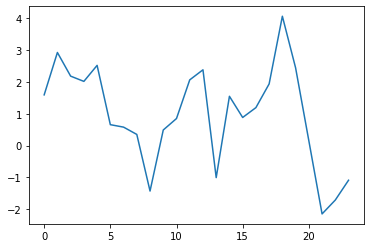

In [69]:
plt.plot(np.mean(error,axis=0));

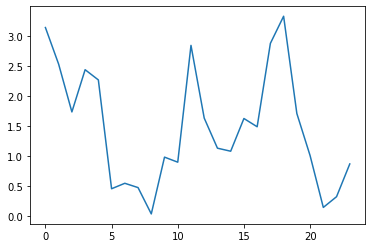

In [70]:
plt.plot(np.percentile(error, 50 ,axis=0));

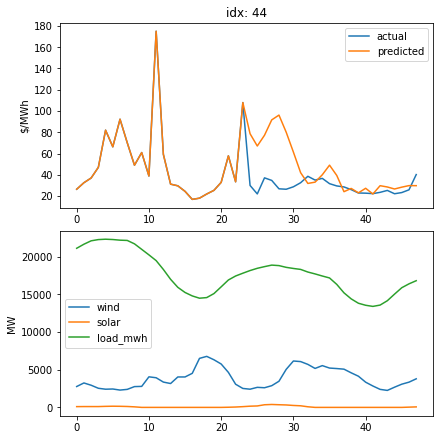

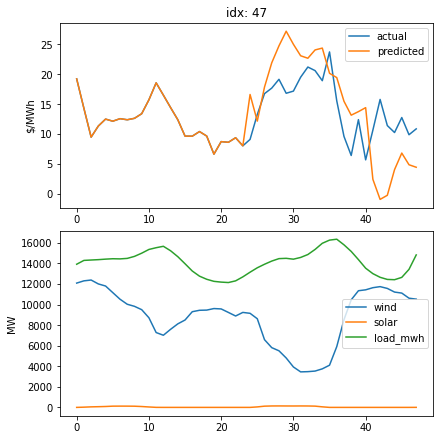

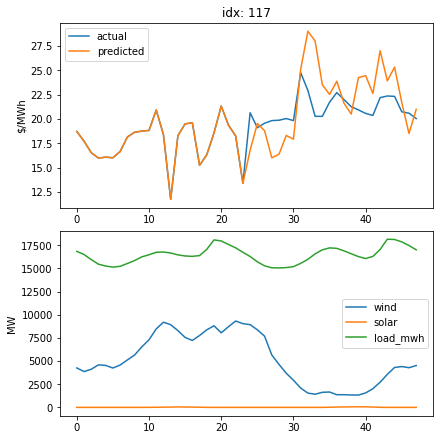

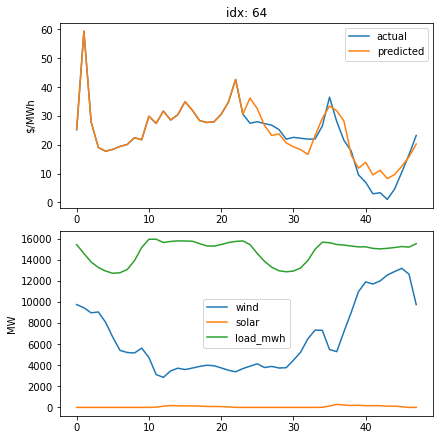

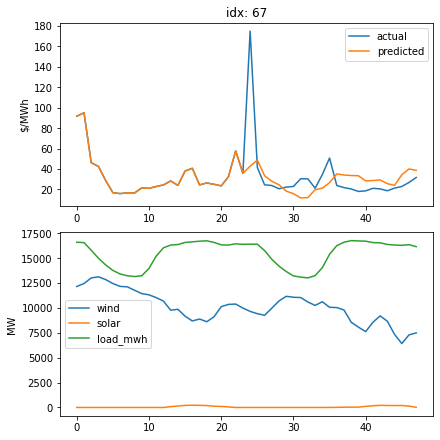

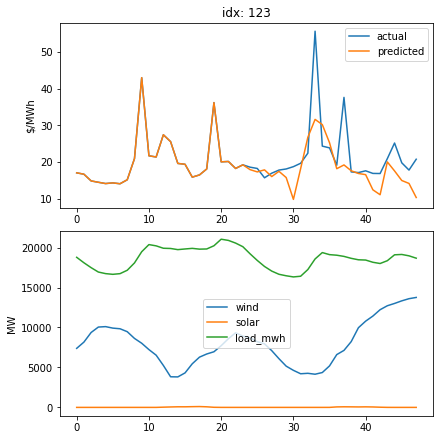

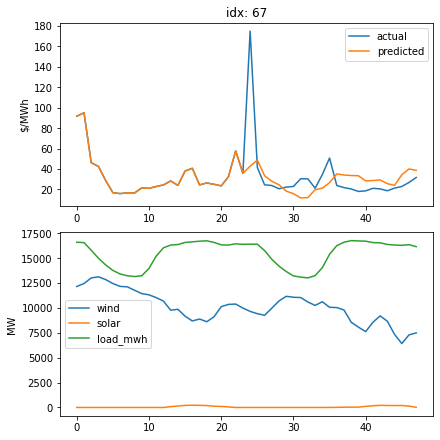

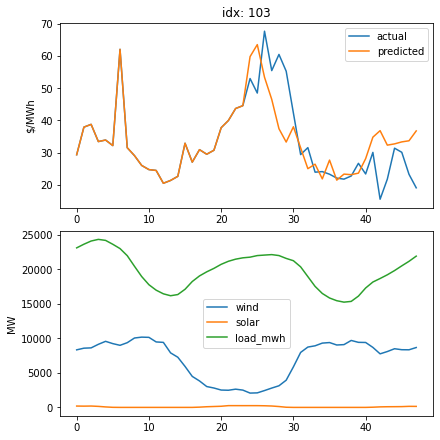

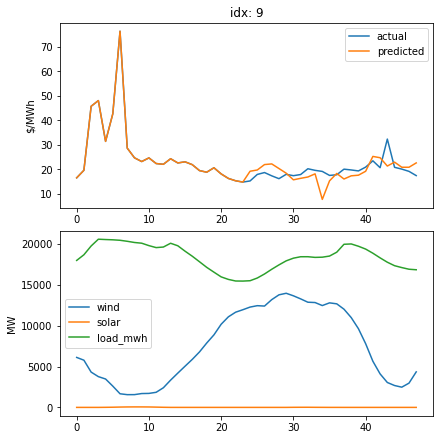

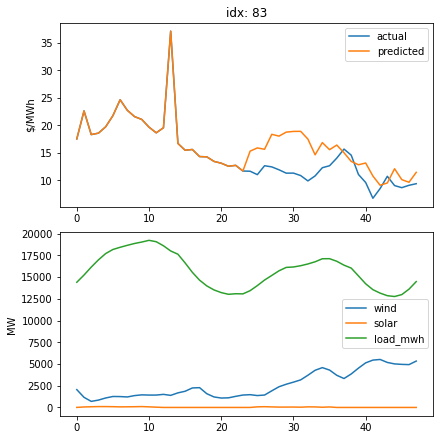

In [71]:
# create some random plots from the last batch of testing data
# to see what the model has learned
N_PLOT = 10

r_idx = np.random.randint(low=0, high=res['label'].shape[0], size=N_PLOT, dtype=int)
for i in r_idx:
    
    hist_future_cols = ['wind', 'solar', 'load_mwh']
    hist_future = res['hist_future'][i,:].cpu().numpy()
    hist_future = np.transpose(hist_future)
    hist_future = (
        hist_future*scaler['sd'][hist_future_cols].values.reshape(1,-1)+
        scaler['means'][hist_future_cols].values.reshape(1,-1)
    )

    hist_future = pd.DataFrame(hist_future, columns=hist_future_cols)

    hist = res['hist'][i,:][0].cpu().numpy()
    
    actual = res['label'][i,:].cpu().numpy()
    actual = np.concatenate([hist, actual])

    predicted = res['output'][i,:].cpu().numpy()
    predicted = np.concatenate([hist, predicted])
    
    comp = pd.DataFrame(
        {'actual':actual, 'predicted':predicted}
    )
    
    fig, axs = plt.subplots(
        ncols=1, 
        nrows=2, 
        figsize=(6, 6),
        constrained_layout=True
    )
    
    comp.plot(ax=axs[0]);
    axs[0].set_ylabel('$/MWh')
    axs[0].set_title(f'idx: {i}');
    hist_future.plot(ax=axs[1]);
    axs[1].set_ylabel('MW')
    plt.show();
    print('=================================================================\n')


## Model serving data testing

* Test model inference on data from the `res` dictionary created above.
* Convert data to json file
* Read in json file
* Test inference on data read from json file

In [72]:
import json
import requests

In [73]:
test_inference_data = {
    'hist_future':res['hist_future'][:1,:,:],
    'hist':res['hist'][:1,:,:],
    'tabular':res['tabular'][:1,:],
}
test_inference_data

{'hist_future': tensor([[[-1.0270e+00, -9.5482e-01, -8.2205e-01, -6.7748e-01, -5.0149e-01,
           -3.3373e-01, -1.9618e-01,  1.0795e-01,  3.6476e-01,  6.0662e-01,
            6.3809e-01,  9.1779e-01,  9.7941e-01,  1.0791e+00,  1.1554e+00,
            1.2018e+00,  1.2105e+00,  1.1997e+00,  1.1452e+00,  1.2111e+00,
            1.3402e+00,  1.4519e+00,  1.5148e+00,  1.4987e+00,  1.4291e+00,
            1.3278e+00,  1.4837e+00,  1.5148e+00,  1.5343e+00,  1.5457e+00,
            1.5486e+00,  1.6503e+00,  1.7333e+00,  1.8572e+00,  1.8105e+00,
            1.8326e+00,  1.8042e+00,  1.7582e+00,  1.7612e+00,  1.7848e+00,
            1.7763e+00,  1.7939e+00,  1.7974e+00,  1.7830e+00,  1.7532e+00,
            1.7200e+00,  1.5688e+00,  1.3435e+00],
          [-6.3491e-01, -6.3491e-01, -6.3491e-01, -6.3491e-01, -6.3491e-01,
           -6.3342e-01, -6.3342e-01, -6.3342e-01, -6.3342e-01, -3.3684e-01,
            1.7526e+00,  1.9806e+00,  2.3413e+00,  2.6752e+00,  3.2534e+00,
            2.7333e+00

In [74]:
model.to(device)
pred_test = model(**test_inference_data)
pred_test

tensor([[11.4827,  9.4336,  6.3577,  4.6521,  5.3740, 10.1376,  5.4985, -1.0352,
          5.4180,  7.1423, 14.6984, 22.6820, 23.5086, 16.9262, 16.5871, 17.4603,
         22.2521, 27.4443, 29.6677, 30.3275, 23.9049, 15.5747,  7.7575, 10.2603]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [75]:
# scripted_model(**test_inference_data)

### Covert data to json

In [76]:
inference_data = {
    'hist_future':res['hist_future'][:1,:,:].cpu().tolist(),
    'hist':res['hist'][:1,:,:].cpu().tolist(),
    'tabular':res['tabular'][:1,:].cpu().tolist(),
}

post_data = json.dumps(inference_data)

In [77]:
post_data

'{"hist_future": [[[-1.0269995746484697, -0.95482254087201, -0.8220518408435661, -0.6774787600391331, -0.5014894450454186, -0.33372529438631077, -0.19618497243602392, 0.10795142949863384, 0.3647566343007177, 0.6066202683884567, 0.638085172189186, 0.9177894291772606, 0.9794051572696393, 1.0791048563195909, 1.1553701374576304, 1.2017766119727042, 1.2105128072275084, 1.1997324882919145, 1.145173853859405, 1.2110725077591529, 1.3401929869290439, 1.4518897452007735, 1.5147708831907842, 1.4986855766074267, 1.429063697431954, 1.3278065708156865, 1.4836953362816345, 1.514819552802232, 1.5343360669926303, 1.5457004212655925, 1.548620597952435, 1.6503400858774526, 1.7332974385895061, 1.8572346041402517, 1.8105117771507697, 1.832583445942155, 1.8041847276626108, 1.7582162796505636, 1.7611851259488533, 1.7847655526951072, 1.7762970403032639, 1.7939154396472141, 1.7973953168657018, 1.7829647770715544, 1.7531789748657598, 1.7200106346643727, 1.5688184867030963, 1.3435025205074655], [-0.6349115634230

In [78]:
# with open('post_data.json', 'w', encoding='utf-8') as f:
#     json.dump(post_data, f, ensure_ascii=False, indent=4)

In [79]:
with open('post_data.txt', 'w', encoding='utf-8') as f:
    json.dump(post_data, f)

### Read json data

In [80]:
with open('post_data.txt', 'r') as f:
    post_data = f.read()

In [81]:
post_data

'"{\\"hist_future\\": [[[-1.0269995746484697, -0.95482254087201, -0.8220518408435661, -0.6774787600391331, -0.5014894450454186, -0.33372529438631077, -0.19618497243602392, 0.10795142949863384, 0.3647566343007177, 0.6066202683884567, 0.638085172189186, 0.9177894291772606, 0.9794051572696393, 1.0791048563195909, 1.1553701374576304, 1.2017766119727042, 1.2105128072275084, 1.1997324882919145, 1.145173853859405, 1.2110725077591529, 1.3401929869290439, 1.4518897452007735, 1.5147708831907842, 1.4986855766074267, 1.429063697431954, 1.3278065708156865, 1.4836953362816345, 1.514819552802232, 1.5343360669926303, 1.5457004212655925, 1.548620597952435, 1.6503400858774526, 1.7332974385895061, 1.8572346041402517, 1.8105117771507697, 1.832583445942155, 1.8041847276626108, 1.7582162796505636, 1.7611851259488533, 1.7847655526951072, 1.7762970403032639, 1.7939154396472141, 1.7973953168657018, 1.7829647770715544, 1.7531789748657598, 1.7200106346643727, 1.5688184867030963, 1.3435025205074655], [-0.63491156

In [82]:
post_data_loaded = json.loads(post_data) # returns string
post_data_loaded = json.loads(post_data_loaded) # returns dict

In [83]:
# convert data to tensors
for k in post_data_loaded.keys():
    post_data_loaded[k] = torch.asarray(post_data_loaded[k]).to(device)

In [84]:
post_data_loaded

{'hist_future': tensor([[[-1.0270e+00, -9.5482e-01, -8.2205e-01, -6.7748e-01, -5.0149e-01,
           -3.3373e-01, -1.9618e-01,  1.0795e-01,  3.6476e-01,  6.0662e-01,
            6.3809e-01,  9.1779e-01,  9.7941e-01,  1.0791e+00,  1.1554e+00,
            1.2018e+00,  1.2105e+00,  1.1997e+00,  1.1452e+00,  1.2111e+00,
            1.3402e+00,  1.4519e+00,  1.5148e+00,  1.4987e+00,  1.4291e+00,
            1.3278e+00,  1.4837e+00,  1.5148e+00,  1.5343e+00,  1.5457e+00,
            1.5486e+00,  1.6503e+00,  1.7333e+00,  1.8572e+00,  1.8105e+00,
            1.8326e+00,  1.8042e+00,  1.7582e+00,  1.7612e+00,  1.7848e+00,
            1.7763e+00,  1.7939e+00,  1.7974e+00,  1.7830e+00,  1.7532e+00,
            1.7200e+00,  1.5688e+00,  1.3435e+00],
          [-6.3491e-01, -6.3491e-01, -6.3491e-01, -6.3491e-01, -6.3491e-01,
           -6.3342e-01, -6.3342e-01, -6.3342e-01, -6.3342e-01, -3.3684e-01,
            1.7526e+00,  1.9806e+00,  2.3413e+00,  2.6752e+00,  3.2534e+00,
            2.7333e+00

In [85]:
# check prediction
model.to(device)
pred = model(**test_inference_data)
pred

tensor([[11.4827,  9.4336,  6.3577,  4.6521,  5.3740, 10.1376,  5.4985, -1.0352,
          5.4180,  7.1423, 14.6984, 22.6820, 23.5086, 16.9262, 16.5871, 17.4603,
         22.2521, 27.4443, 29.6677, 30.3275, 23.9049, 15.5747,  7.7575, 10.2603]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [86]:
# check that the predictions from the json formatted data match the 
# predictions from the test data
pred_test.tolist() == pred.tolist()

True

## Torchserve

In [ ]:
# see for custom handler
# https://pytorch.org/serve/custom_service.html

In [87]:
# https://github.com/pytorch/serve/tree/master/model-archiver#creating-a-model-archive
!torch-model-archiver --model-name pytorch_cnn --version 1.0 --export-path /workspace/models --serialized-file $MLFLOW_MODEL_URI --handler /workspace/src/model_handler.py --force

WARNING - Overwriting /workspace/models/pytorch_cnn.mar ...


see https://github.com/pytorch/serve/blob/master/docs/server.md

`torchserve --start --model-store /workspace/models --models miso_price=pytorch_cnn.mar`

This would serve a prediction endpoint at predictions/miso_price/ and run your custom service code in the archive, the manifest in archive would point to the entry point.

In [88]:
# check the status of the torchserve server
# https://github.com/pytorch/serve/blob/master/docs/inference_api.md
!curl http://localhost:8080/ping

{
  "status": "Healthy"
}


In [89]:
req = requests.post(
    "http://localhost:8080/predictions/miso_price", 
    files={'post_data': open('post_data.txt', 'r')}
)

In [90]:
req.status_code, req.reason

(200, '')

In [91]:
req.text

'[\n  11.482740698582097,\n  9.433558322509805,\n  6.357670718767742,\n  4.652072424362834,\n  5.373981184366461,\n  10.13755370668131,\n  5.498537501139509,\n  -1.0351698889924719,\n  5.417987776815796,\n  7.142253999295891,\n  14.698423475187953,\n  22.68197515918935,\n  23.50863570268838,\n  16.926248280318205,\n  16.587138777594447,\n  17.460261308536353,\n  22.252084297007105,\n  27.4442771372184,\n  29.667714488103567,\n  30.327531882724816,\n  23.904924808893337,\n  15.5746969646517,\n  7.75750663936942,\n  10.260269012567438\n]'

In [92]:
# check that the predictions from the api call match the 
# predictions from the test data
all(np.round(pred_test.tolist()[0], 7) == np.round(json.loads(req.text), 7))

True

In [93]:
pd.DataFrame(
    {
        'price_forecast_api':json.loads(req.text),
        'price_forecast_test_data':pred_test.tolist()[0]
    }
)

,price_forecast_api,price_forecast_test_data
0,11.482741,11.482741
1,9.433558,9.433558
2,6.357671,6.357671
3,4.652072,4.652072
4,5.373981,5.373981
5,10.137554,10.137554
6,5.498538,5.498538
7,-1.035170,-1.035170
8,5.417988,5.417988
9,7.142254,7.142254


## Save notebook to html

In [94]:
!jupyter nbconvert --to html /workspace/src/build_model.ipynb

[NbConvertApp] Converting notebook /workspace/src/build_model.ipynb to html
[NbConvertApp] Writing 1380340 bytes to /workspace/src/build_model.html
